## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [24]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [25]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text

In [26]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [27]:
data_set = pd.read_feather("/home/raquel/zrive-ds/src/module_5/financials_against_return.feather")

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [28]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]


In [29]:
data_set.shape

(170483, 145)

In [30]:
data_set.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773,1962
1,NDSN,2005-01-31,0.2248,-3.366,10.663,7.700,62.6220,NaN,NaN,-21.145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846,1962
2,HURC,2005-01-31,0.3782,0.483,-0.400,2.866,11.3030,0.156,0.854,-0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440,1962
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322,1962
4,HRL,2005-01-31,0.4880,-12.075,-113.077,83.476,145.2050,NaN,17.084,3.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482,1962


In [31]:
data_set.dtypes

Ticker                                     object
date                               datetime64[ns]
AssetTurnover                             float64
CashFlowFromFinancialActivities           float64
CashFlowFromInvestingActivities           float64
                                        ...      
CurrentRatio_change_2_years               float64
Market_cap__minus_365                     float64
Market_cap__minus_730                     float64
diff_ch_sp500                             float64
count                                       int64
Length: 145, dtype: object

# Target creation

In [32]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

# Functions for weighted performance of top stocks

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [134]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

# Temporal train-test split

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [133]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [135]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [136]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test


 
            

# Trains and evaluates a model

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [137]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )


# Loop for every execution date

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [138]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [40]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [41]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [42]:
train_results

,binary_logloss,weighted-return,n_trees,execution_date
0,0.657505,0.267845,0,2006-06-30
1,0.639193,0.483940,1,2006-06-30
2,0.619754,0.218716,2,2006-06-30
3,0.601840,0.247316,3,2006-06-30
4,0.585715,0.250948,4,2006-06-30
...,...,...,...,...
35,0.621253,0.431394,35,2020-03-31
36,0.620597,0.487939,36,2020-03-31
37,0.619887,0.487939,37,2020-03-31
38,0.619180,0.487939,38,2020-03-31


In [43]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

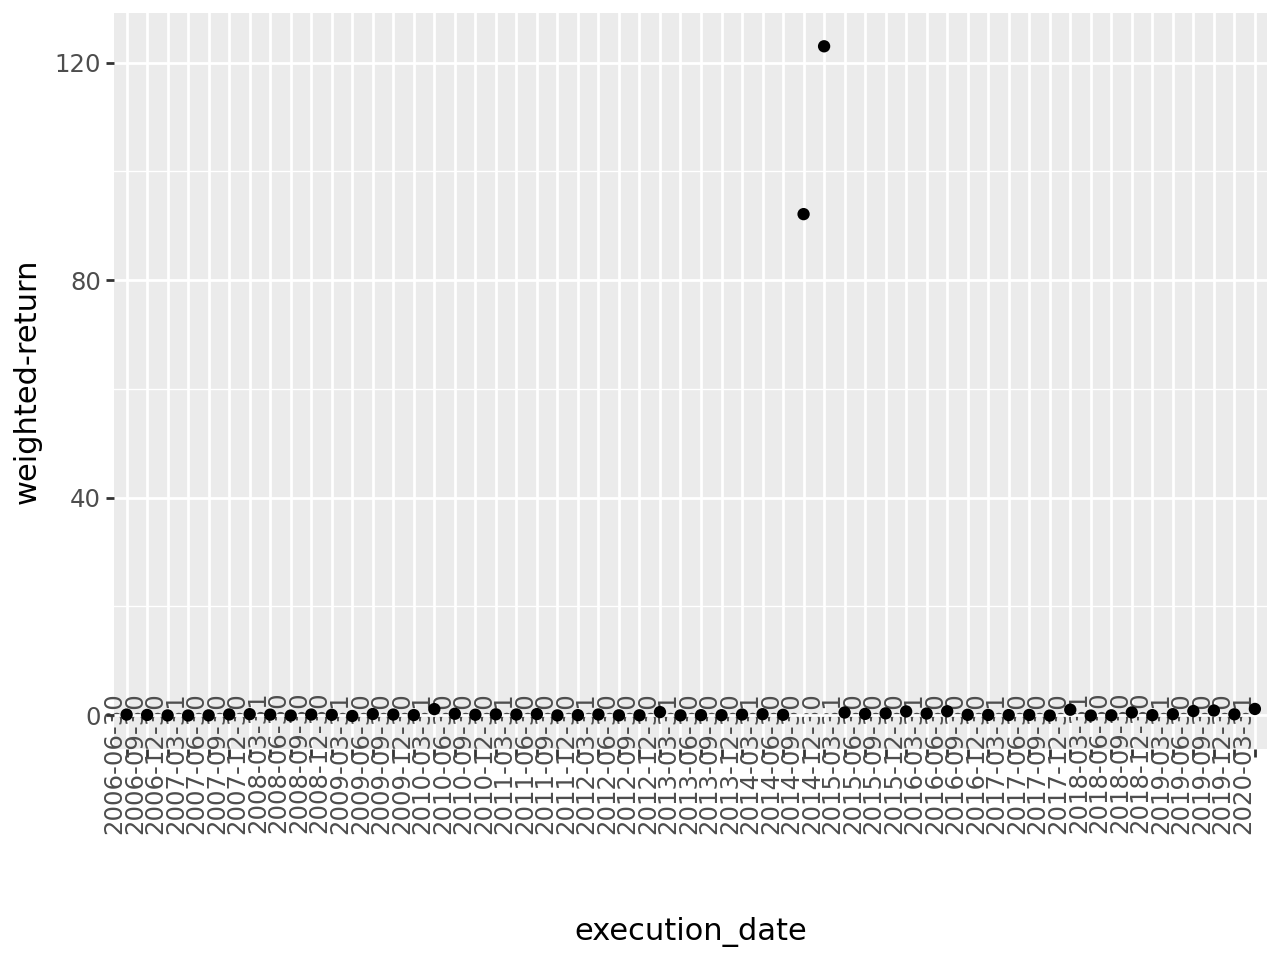

In [44]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



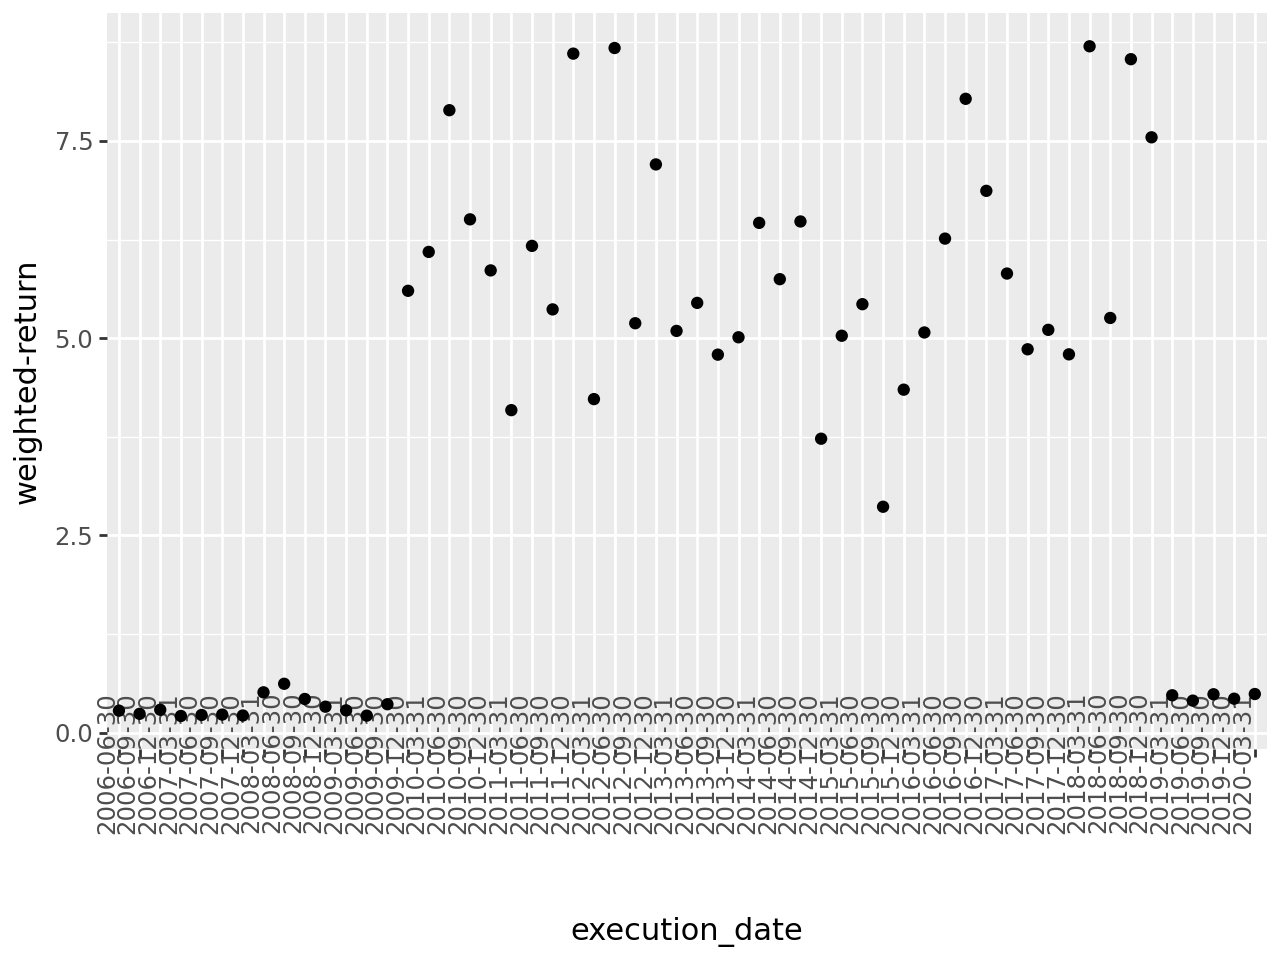

In [45]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [46]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot


# Temporal evolution of the number of good stocks

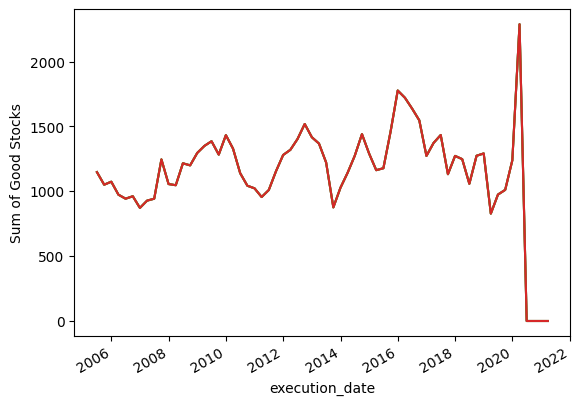

In [ ]:
import matplotlib.pyplot as plt
data_set.groupby('execution_date')['target'].sum().plot(kind='line')
plt.ylabel('Sum of Good Stocks')
plt.show()

The number of good stocks remains steady over time.

# Feature importance given model

Correlation with target

In [54]:
columns_to_remove = [
                        "date",
                        "improve_sp500",
                        "Ticker",
                        "freq",
                        "set",
                        "close_sp500_365",
                        "close_365",
                        "stock_change_365",
                        "sp500_change_365",
                        "stock_change_div_365",
                        "stock_change_730",
                        "sp500_change_365",
                        "stock_change_div_730",
                        "diff_ch_sp500",
                        "diff_ch_avg_500",
                        "execution_date","index","quarter","std_730","count"]

data = data_set.drop(columns=columns_to_remove, errors="ignore")
correlations_with_target = data.corr()['target'].drop('target').abs().sort_values(ascending=False)
print(correlations_with_target.head(10))


close_sp500_0                     0.118969
sp500_change__minus_730           0.096277
sp500_change__minus_365           0.070113
stock_change__minus_365           0.043080
stock_change_div__minus_365       0.042152
ResearchAndDevelopmentExpenses    0.039150
stock_change__minus_730           0.036100
stock_change__minus_120           0.035543
stock_change_div__minus_120       0.034918
stock_change_div__minus_730       0.034647
Name: target, dtype: float64


Mean feature importance in every iteration of the 15 top features

In [55]:
def mean_feature_importance(model,top = 15):
 
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    #feature_importance.plot(kind="barh", x="feature", y="imp", ax=ax)

    #plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return feature_importance
    

In [ ]:
import lightgbm as lgb
all_feature_importance = []
for execution_date in execution_dates[4:-5]:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
    feature_importance = mean_feature_importance(model)
    all_feature_importance.append(feature_importance)

all_feature_importances_df = pd.concat(all_feature_importance, axis=0)
mean_feature_importance = all_feature_importances_df.groupby('feature')['imp'].mean().reset_index()
mean_feature_importance = mean_feature_importance.sort_values('imp', ascending=False)

2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30

In [ ]:
mean_feature_importance

,feature,imp
43,close_0,89.690909
45,sp500_change_730,52.025000
44,close_sp500_0,51.787234
48,sp500_change__minus_730,49.823529
47,sp500_change__minus_365,33.789474
51,std__minus_730,29.711111
49,std__minus_120,29.076923
46,sp500_change__minus_120,28.500000
24,NetTotalEquityIssuedRepurchased,28.000000
53,stock_change__minus_365,27.550000


- The features close_0, close_sp500_0, and sp500_change_730 introduce future information that won't be available in a production environment. To avoid data leakage, we will drop these features from the dataset.

- To speed up testing, we will select only the top 15 most important features from each iteration.

In [62]:
train_cols = mean_feature_importance[3:]
train_cols.head(3)

,feature,imp
48,sp500_change__minus_730,49.823529
47,sp500_change__minus_365,33.789474
51,std__minus_730,29.711111


# Overfitting given model

Let's study the evolution of log loss across n_estimators for both training and validation.

In [146]:
#All results has the eval_result of every execution_date
def plot_all_results(all_results):
    
    for execution_date, eval_result in all_results.items():
        valid_logloss = eval_result['valid_0']['binary_logloss']
        train_logloss = eval_result['training']['binary_logloss']
        n_estimators = list(range(0, n_trees))  
        plt.plot(n_estimators, valid_logloss, color='blue', linestyle='--')
        plt.plot(n_estimators, train_logloss, color='red')

    plt.xlabel('Number of Estimators (Iterations)')
    plt.ylabel('Binary Logloss')
    plt.title('Binary Logloss over Number of Estimators for Each Execution Date')
    plt.legend(['Validation', 'Train'], loc='upper right')
    plt.grid(True)
    plt.tight_layout()  
    plt.show()

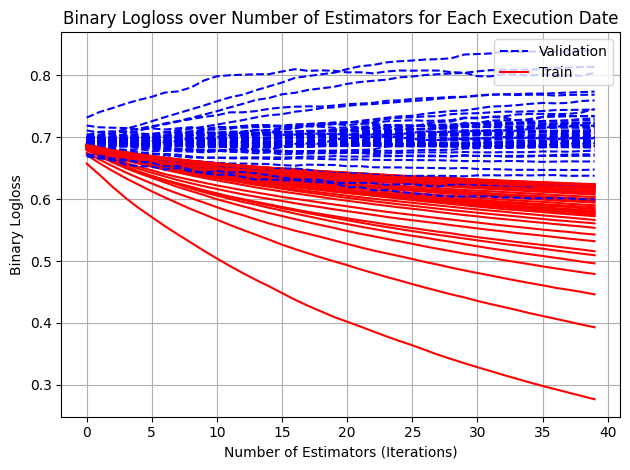

In [147]:
plot_all_results(all_results)

There is a clear overfitting in the given model with the value of log loss. I am going to evaluate other metric, the auc and ap.

# Retraining the model

With less features and with auc metric to study overfitting easily (in feval)

In [112]:
train_cols.head(4)

,feature,imp
48,sp500_change__minus_730,49.823529
47,sp500_change__minus_365,33.789474
51,std__minus_730,29.711111
49,std__minus_120,29.076923


In [156]:
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    roc_curve,
    roc_auc_score,
    average_precision_score,
)
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

def get_roc_auc_of_top_tickers(df, metric, y_true):
    # We need to calculate the AUC on the 'prob' column (predicted probabilities)
    # and use the true labels (y_true) for evaluation.
    
    # Get the predicted probabilities for the metric you're interested in
    y_pred = df["prob"]
    
    # Compute the ROC AUC score for the top tickers
    roc_auc = roc_auc_score(y_true, y_pred)
    
    return roc_auc

# Main function to calculate the ROC AUC for top tickers
def top_roc_auc_performance(preds, train_data, top_n=10):
    # Get the top tickers based on predicted probabilities
    top_dataset = get_top_tickers_per_prob(preds, top_n)
    
    # Ensure the train_data has the true labels (y_true)
    y_true = top_dataset["target"]  # Assuming 'target' is the true binary label column
    
    # Calculate ROC AUC for the top tickers
    roc_auc = get_roc_auc_of_top_tickers(top_dataset, "prob", y_true)
    
    return "roc_auc", roc_auc, True



In [114]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

In [128]:
def train_model_fi(train_set,test_set,n_estimators = 300):
    columns_to_remove = get_columns_to_remove()
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    X_train = X_train[train_cols]
    X_test = X_test[train_cols]

    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_curves],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test

In [125]:
def run_model_for_execution_date_fi(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model_fi(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


In [157]:
all_results_fi = {}
all_predicted_tickers_list_fi = []
all_models_fi = {}

for execution_date in execution_dates[0:36]:
    print(execution_date)
    all_results_fi,all_predicted_tickers_list_fi,all_models_fi,model_fi,X_train_fi,X_test_fi = run_model_for_execution_date_fi(execution_date,all_results_fi,all_predicted_tickers_list_fi,all_models_fi,n_trees,False)
all_predicted_tickers_fi = pd.concat(all_predicted_tickers_list_fi) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000
2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30

In [160]:
all_results_fi

{numpy.datetime64('2006-06-30T00:00:00.000000000'): {'training': OrderedDict([('binary_logloss',
                [0.6785864861070873,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.678586486107087,
                 0.678586486107087,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.678586486107087,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070873,
                 0

In [158]:
#All results has the eval_result of every execution_date
def plot_all_results(all_results):
    
    for execution_date, eval_result in all_results.items():
        valid_logloss = eval_result['valid_0']['aucs']
        train_logloss = eval_result['training']['aucs']
        n_estimators = list(range(0, n_trees))  
        plt.plot(n_estimators, valid_logloss, color='blue', linestyle='--')
        plt.plot(n_estimators, train_logloss, color='red')

    plt.xlabel('Number of Estimators (Iterations)')
    plt.ylabel('ROC AUC')
    plt.title('ROC AUC over Number of Estimators for Each Execution Date')
    plt.legend(['Validation', 'Train'], loc='upper right')
    plt.grid(True)
    plt.tight_layout()  
    plt.show()

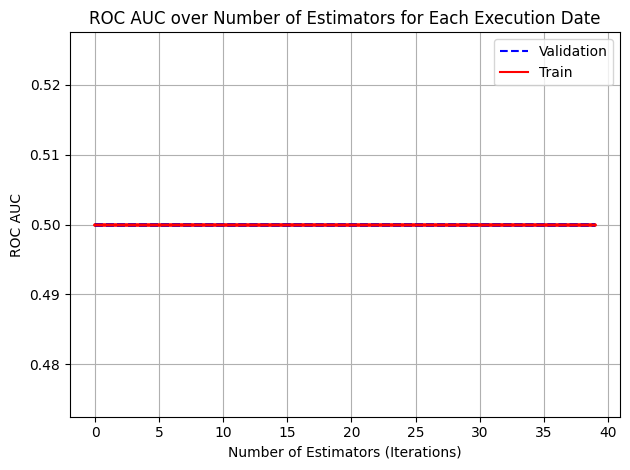

In [159]:
plot_all_results(all_results_fi)

In [149]:
all_results_fi

{numpy.datetime64('2006-06-30T00:00:00.000000000'): {'training': OrderedDict([('binary_logloss',
                [0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070873,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070873,
                 0.6785864861070872,
                 0.6785864861070873,
               